In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense
from sklearn.utils.class_weight import compute_class_weight

# Read data
Data = pd.read_excel(r"/content/drive/MyDrive/Thesis/Product Review Sentiment Analysis.xlsx")

# Define Bangla stopwords
bangla_stopwords = [
    'এই', 'সে', 'এ', 'তার', 'যে', 'আমাদের', 'তাদের', 'আমরা', 'তোমরা',
    'তুমি', 'তারা', 'যার', 'কোন', 'কিছু', 'এক', 'অনেক', 'অধিক', 'সব',
    'কত', 'কোথায়'
]

# Preprocessing function
def preprocess_text(text):
    text = re.sub('<[^<]+?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if len(word) > 1])  # Remove single characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Apply preprocessing to the 'Reviews' column
Data['Reviews'] = Data['Reviews'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

# Download NLTK data (you only need to do this once)
nltk.download('punkt')

# Tokenization function
def tokenize_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = word_tokenize(text)
    return tokens

# Remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in bangla_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Apply stopword removal
Data['Cleaned_Reviews'] = Data['Reviews'].apply(remove_stopwords)

# Apply tokenization
Data['Tokenized_Reviews'] = Data['Reviews'].apply(lambda x: tokenize_text(x) if pd.notnull(x) else x)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Drop NaN values
Data = Data.dropna(subset=['Tokenized_Reviews'])

# Convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Data['Cleaned_Reviews'])
X = tokenizer.texts_to_sequences(Data['Cleaned_Reviews'])
X = pad_sequences(X, padding='post')

# Encoding sentiments
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Data['Sentiments'])  # Use label encoder instead of one-hot encoding

In [4]:
import os
# Download and unzip the embeddings file
if not os.path.exists('wiki-news-300d-1M.vec'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2024-05-22 07:17:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   160MB/s    in 3.9s    

2024-05-22 07:17:55 (167 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [5]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [6]:
# Load pre-trained word embeddings
embeddings_index = {}
with open('wiki-news-300d-1M.vec', encoding='utf-8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        vec = np.array(vec.split(' '), dtype=np.float32) # Use numpy.array instead of array
        embeddings_index[word] = vec

# Define embedding dimension and maximum vocabulary size
embedding_dim = 300
max_features = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(y_train.shape)

(2857,)


In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize SVM model with RBF kernel
svm_model = SVC(kernel='rbf')

# Train the model
svm_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.63      0.70       340
           1       0.71      0.84      0.77       375

    accuracy                           0.74       715
   macro avg       0.75      0.73      0.73       715
weighted avg       0.74      0.74      0.74       715



In [10]:
# prompt: accuracy for this

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.7384615384615385


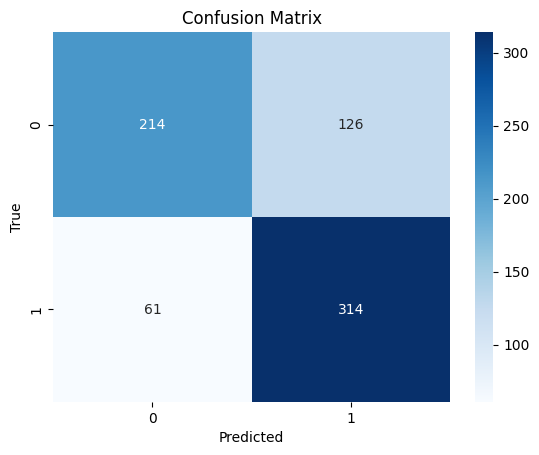

In [12]:
# prompt: display confusion matrix for this

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()
